# Game Theory Project

In [1]:
import networkx as nx
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
#import pulp
#from IPython.display import Image

%matplotlib inline

In [21]:
from functools import wraps
import errno
import os
import signal

class TimeoutError(Exception):
    pass

def timeout(seconds=10, error_message=os.strerror(errno.ETIME)):
    def decorator(func):
        def _handle_timeout(signum, frame):
            raise TimeoutError(error_message)

        def wrapper(*args, **kwargs):
            signal.signal(signal.SIGALRM, _handle_timeout)
            signal.alarm(seconds)
            try:
                result = func(*args, **kwargs)
            finally:
                signal.alarm(0)
            return result

        return wraps(func)(wrapper)
    return decorator

In [45]:
def node_numbers(node):
    
    if node[0]=='source': return 0
    if node[0]=='sink': return 1
    if node[0]=='destination': return float('inf')
    else:
        cost= 2+2*int(node[0][0])
        if node[0][1:]=='out': cost+=1
        return cost

def sort_nodes(nodes):
    return sorted(nodes,key=node_numbers)

def edge_numbers(edge):
    pass

def distance(node1,node2):
    '''Simple distance formula between two points'''
    x1 = node1[0]
    x2 = node2[0]
    y1 = node1[1]
    y2 = node2[1]
    return sqrt((x2-x1)**2 + (y2-y1)**2)

def max_distance(points):
    '''Gets the maximum distance between two points in the graph'''
    current = 0
    for node1 in points:
        for node2 in points:
            d = distance(node1,node2) # Find the distance between the two nodes
            if d>current: # if it's a greater distance, store that distance as the greatest
                current=d
    return current

@timeout(seconds=3)
def cost_of_min_flow(G):
    '''Given a graph, it gives the cost of the paths in the max flow min cost over the graph'''
    #import pdb;pdb.set_trace()
    flow_path = nx.max_flow_min_cost(G,'source','sink',weight='cost')# Gets the flow path from source to sink
    beginning = flow_path['source'] # The beginning has the directions for where each cab starts
    
    total_cost = 0
    start_paths = [n[0] for n in beginning.items() if n[1]==1] # each node which the flow_path indicates to go
    paths = []
    for start_node in start_paths: # For each node that a cab goes to in order to start
        path = [start_node]
        curr_node=start_node
        path_cost = 0
        while curr_node!='destination': # Loop through the path until you reach the destination
            next_node = [n for n in flow_path[curr_node].items() if n[1]==1][0][0] # each node the current node travels to
            path_cost += G.edge[curr_node][next_node]['cost'] # Add the cost of the edge from the current node to the next node
            curr_node = next_node # Switch current node to be the node travelled to
            if G.node[curr_node]['type']=='passenger in': path.append(curr_node)
        total_cost += path_cost # When that node is finished, add it to the total cost and start over
        paths.append(path+['destination'])
    return total_cost, paths    

def generate_graph(passengers, destination, complete=False):
    G=nx.DiGraph() # Create a directed graph
    
    # The rest of the algorithm closely follows Raga's paper - I quote the steps directly
    
    # Step 1
    # "s and t denote the source and sink vertices, respectively"
    G.add_node("source", type="meta")
    G.add_node("sink", type="meta")
    
    # Step 2
    # For each passenger/pickup location u ∈ N , we create two vertices and an edge: an
    # entry vertex u_in, an exit vertex u_out, and an edge of cost 0 and capacity 1 directed
    # from u_in to u_out. We also create a vertex n+1 corresponding to the dropoff location.
    i = 1
    for passenger in passengers:
        # {}in.format(x) will give the node the name xin, for any integer x
        G.add_node("{}in".format(i), number=i, x=passenger[0], y=passenger[1], type="passenger in")
        G.add_node("{}out".format(i),number=i, x=passenger[0], y=passenger[1], type="passenger out")
        G.add_edge("{}in".format(i), "{}out".format(i), cost=0, capacity=1)
        i+=1
    G.add_node("destination", x=destination[0], y=destination[1], type="destination")
    
    # Step 3
    # We create n edges, one each of cost 0 and capacity 1 from the source vertex s to each
    # of the entry vertices u_in, u ∈ N.
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger in":
            G.add_edge("source", node[0], cost=0, capacity=1)
    
    # Calculating L
    # passengers + [destination] is the concatonation of the two lists
    L = len(passengers)*max_distance(passengers + [destination]) + 1 
    L = round(L, 2)
    
    
    # Step 4
    # We create n edges, one each of cost SuD and capacity 1 from each 
    # of the exit vertices uout, u ∈ N, to the dropoff vertex n + 1
    for node in G.nodes(data=True):
        if node[1]['type']=="passenger out":
            cost = distance(destination, (node[1]['x'],node[1]['y']))-L # Calculating SuD
            cost = round(cost, 2)
            node_name = node[0]
            G.add_edge(node_name,"destination", cost=cost, capacity=1) # Creating the edge with that cost
    
    # Step 5
    # To encode the pickup order, for each 1 ≤ u < v ≤ n we create an edge of cost
    # (SuSv − L) and capacity 1 directed from u_out to v_in, where L is a sufficiently large
    # number satisfying L > 2*max [u,v∈N∪{n+1} SuSv].
    
    
    for u in range(1,len(passengers)+1): # For each u
        if complete: # If we want a complete graph we will do every v, otherwise just v>u
            start = 1
        else: 
            start = u+1
        for v in range(start, len(passengers)+1):
            if u!=v:
                G.add_edge("{}out".format(u), "{}in".format(v), 
                           cost=round(distance(passengers[u-1], passengers[v-1])-L, 2), capacity=1) 
    print "L = {}".format(L)
    return G
    

def allocation(G):
    '''
    Given a list of passengers and a destination, gives a graph with a minimum cost (iterating over m')
    passengers is a list of tuples - ID, x, y
    destination is a tuple
    complete=True if we want the passenger inputs to not be ordered
    '''        
    # Step 6
    # We add a final edge of cost 0 and capacity m′ from the dropoff vertex n + 1 to the
    # sink vertex t, thereby limiting the maximum flow in the network to m′ units.
    
    # In this implementation, we make n copies of this graph, and give each one an m' from i to n
    #import pdb;pdb.set_trace()
    passengers = [node for node in G.nodes(data=True) if node[1]['type']=='passenger in']
    possible_graphs = [G.copy() for i in range(len(passengers))]
    for i, pg in enumerate(possible_graphs, 1):
        #pg.node["source"]["demand"] = -(i)
        #pg.node["sink"]["demand"] = (i)
        
        pg.add_edge("destination", "sink", cost=0, capacity=i) # All the different m' values
    
    # Now over these graphs we have to find the one with the lowest cost in the min cost max flow algorithm
    # Aka which m' gives the lowest cost
    min_cost = float('inf')
    min_flow_graph = None
    costs = []
    paths = []
    optimal = 0
    #import pdb;pdb.set_trace()
    
    for index, pg in enumerate(possible_graphs):
        #import pdb;pdb.set_trace()
        try:
            print "{} cabs: ".format(index+1),
            # For each possible graph, calculate the cost. If the cost is less than previous graphs, store it
            c, path = cost_of_min_flow(pg)
            c = round(c,2)
            paths.append(path)
            costs.append(c)
            print "path: ",path,"--",
            print "cost: ",c
            if c<min_cost:
                min_cost=c
                min_flow_graph=pg
                optimal = index
            #print "ok"
        except TimeoutError:
            paths.append([])
            costs.append(float('inf'))
            print "timed out"
    #print "# cabs, costs", list(enumerate(costs, 1))
    print "Optimal path with {} cabs".format(optimal+1), paths[optimal]
    return min_flow_graph,paths[optimal]  # return the minimum graph

def allocation_interractive():
    players = int(raw_input("How many players are there: "))
    player_coordinates = []
    for i in range(1,players+1):
        coord = raw_input("What are the x and y coordinates for player {}: ".format(i))
        coord = [int(x) for x in coord.split()]
        player_coordinates.append((coord[0],coord[1]))
    destination = raw_input("What are the x and y coordinates for the destination: ")
    destination = [int(x) for x in destination.split()]
    return (generate_graph(player_coordinates, (destination[0], destination[1])))
    
def operational_cost(G, route, meter_fare = 8):
    oc = 0
    oc_values = []
    players_on_route = 1
    #import pdb;pdb.set_trace()
    for i in range(len(route)-1):
        first = G.node[route[i]]
        second = G.node[route[i+1]]
        oc += meter_fare*(distance( (first['x'], first['y']), (second['x'], second['y']) ) / float(players_on_route) )
        oc_values.append((distance( (first['x'], first['y']), (second['x'], second['y']) ) / float(players_on_route) ))
        players_on_route +=1
    #print oc_values
    return oc
    
def shared_cost_per_player(G, route, meter_fare=8):
    operational_costs = []
    inconvenience_costs = [0]
    for i in range(len(route)-1):
        #import pdb;pdb.set_trace()
        operational_costs.append(operational_cost(G, route[i:], meter_fare)) 
    
    #IC(i) is the inconvenience cost caused due to player(i) to other players
    for i in range(1,len(route)-1):
        #import pdb;pdb.set_trace()
        first = G.node[route[i-1]]
        second = G.node[route[i]]
        destination = G.node["destination"]
        new_distance = (distance( (first['x'], first['y']), (second['x'], second['y']) )+
                             distance( (second['x'], second['y']), 
                                      (destination['x'], destination['y']) ))
        original_distance = distance( (first['x'], first['y']), (destination['x'], destination['y']) )
        
        inconvenience_costs.append((new_distance-original_distance)*meter_fare)
    
    total_cost = []
    for i in range(len(route)-1):
        total_cost.append(operational_costs[i]+i*inconvenience_costs[i])
    
    #print operational_costs
    #print inconvenience_costs
    return total_cost
    
def original_cost_per_player(G, meter_fare=8):
    costs = []
    players = [n for n in G.nodes(data=True) if n[1]['type']=='passenger in']
    destination = G.node["destination"]
    for player in players:
        costs.append(meter_fare*(distance((player[1]['x'], player[1]['y']), 
                                          (destination['x'], destination['y']) )))
    return costs

In [46]:
# This example creates a graph where the players are at positions (1,1), (-1,1), (-1,-1), (1,-1) and destination (0,0)
G = generate_graph([(2,2), (1,1), (1,0), (1,-1), (3,1), (3,0), (3,-1)], (2,-2))
#G = generate_graph([(1,1), (0,1), (-1,1), (-1,0), (-1,-1), (0,-1), (1,-1), (1,0)], (0,0))
#G = generate_graph([(3,3), (1,3), (1,1), (3,1)], (3,2))
#G = generate_graph([(1,0), (1,1), (1,2), (2,0), (2,1), (2,2)], (4,1))
#G = generate_graph([(1,0), (1,1), (2,0), (5,1)], (4,0))

#type(G)
#G = allocation_interractive()

a, paths = allocation(G)
print paths
print "Costs: "
print [shared_cost_per_player(G, path, meter_fare=1) for path in paths]
print original_cost_per_player(G, meter_fare=1)
#print new_allocation

L = 29.0
1 cabs:  path:  [['1in', '2in', '3in', '4in', '5in', '6in', '7in', 'destination']] -- cost:  -193.35
2 cabs:  path:  [['1in', '2in', '3in', '4in', 'destination'], ['5in', '6in', '7in', 'destination']] -- cost:  -194.77
3 cabs:  path:  [['1in', '2in', '3in', 'destination'], ['5in', '6in', '7in', 'destination'], ['4in', 'destination']] -- cost:  -193.53
4 cabs:  path:  [['1in', '2in', '3in', 'destination'], ['7in', 'destination'], ['5in', '6in', 'destination'], ['4in', 'destination']] -- cost:  -192.29
5 cabs:  path:  [['1in', '2in', '3in', 'destination'], ['7in', 'destination'], ['6in', 'destination'], ['5in', 'destination'], ['4in', 'destination']] -- cost:  -190.13
6 cabs:  path:  [['1in', '2in', 'destination'], ['7in', 'destination'], ['6in', 'destination'], ['5in', 'destination'], ['4in', 'destination'], ['3in', 'destination']] -- cost:  -187.97
7 cabs:  path:  [['1in', 'destination'], ['7in', 'destination'], ['6in', 'destination'], ['5in', 'destination'], ['2in', 'destinat

In [10]:
# All the nodes in the graph

sort_nodes(a.nodes(data=True))

[('source', {'type': 'meta'}),
 ('sink', {'type': 'meta'}),
 ('1in', {'number': 1, 'type': 'passenger in', 'x': 2, 'y': 2}),
 ('1out', {'number': 1, 'type': 'passenger out', 'x': 2, 'y': 2}),
 ('2in', {'number': 2, 'type': 'passenger in', 'x': 1, 'y': 1}),
 ('2out', {'number': 2, 'type': 'passenger out', 'x': 1, 'y': 1}),
 ('3in', {'number': 3, 'type': 'passenger in', 'x': 1, 'y': 0}),
 ('3out', {'number': 3, 'type': 'passenger out', 'x': 1, 'y': 0}),
 ('4in', {'number': 4, 'type': 'passenger in', 'x': 1, 'y': -1}),
 ('4out', {'number': 4, 'type': 'passenger out', 'x': 1, 'y': -1}),
 ('5in', {'number': 5, 'type': 'passenger in', 'x': 3, 'y': 1}),
 ('5out', {'number': 5, 'type': 'passenger out', 'x': 3, 'y': 1}),
 ('6in', {'number': 6, 'type': 'passenger in', 'x': 3, 'y': 0}),
 ('6out', {'number': 6, 'type': 'passenger out', 'x': 3, 'y': 0}),
 ('7in', {'number': 7, 'type': 'passenger in', 'x': 3, 'y': -1}),
 ('7out', {'number': 7, 'type': 'passenger out', 'x': 3, 'y': -1}),
 ('destinati

In [12]:
# All the edges in the graph
a.edges(data=True)

[('1in', '1out', {'capacity': 1, 'cost': 0}),
 ('6out', '7in', {'capacity': 1, 'cost': -28.0}),
 ('6out', 'destination', {'capacity': 1, 'cost': -26.76}),
 ('source', '1in', {'capacity': 1, 'cost': 0}),
 ('source', '7in', {'capacity': 1, 'cost': 0}),
 ('source', '6in', {'capacity': 1, 'cost': 0}),
 ('source', '5in', {'capacity': 1, 'cost': 0}),
 ('source', '2in', {'capacity': 1, 'cost': 0}),
 ('source', '4in', {'capacity': 1, 'cost': 0}),
 ('source', '3in', {'capacity': 1, 'cost': 0}),
 ('7in', '7out', {'capacity': 1, 'cost': 0}),
 ('2out', '7in', {'capacity': 1, 'cost': -26.17}),
 ('2out', 'destination', {'capacity': 1, 'cost': -25.84}),
 ('2out', '6in', {'capacity': 1, 'cost': -26.76}),
 ('2out', '5in', {'capacity': 1, 'cost': -27.0}),
 ('2out', '4in', {'capacity': 1, 'cost': -27.0}),
 ('2out', '3in', {'capacity': 1, 'cost': -28.0}),
 ('destination', 'sink', {'capacity': 2, 'cost': 0}),
 ('6in', '6out', {'capacity': 1, 'cost': 0}),
 ('5in', '5out', {'capacity': 1, 'cost': 0}),
 ('2in

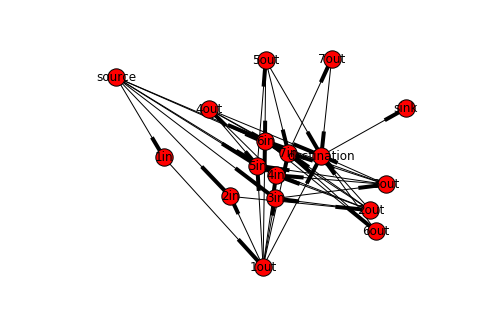

In [13]:
# Drawing of the graph (not very well done)
nx.draw(a, with_labels=True)

In [14]:
# The path that should be taken
# Starting from the source, a 1 in the node in the dictionary means send 1 cab there


nx.max_flow_min_cost(a,'source','sink',weight='cost')

{'1in': {'1out': 1},
 '1out': {'2in': 1,
  '3in': 0,
  '4in': 0,
  '5in': 0,
  '6in': 0,
  '7in': 0,
  'destination': 0},
 '2in': {'2out': 1},
 '2out': {'3in': 1, '4in': 0, '5in': 0, '6in': 0, '7in': 0, 'destination': 0},
 '3in': {'3out': 1},
 '3out': {'4in': 1, '5in': 0, '6in': 0, '7in': 0, 'destination': 0},
 '4in': {'4out': 1},
 '4out': {'5in': 0, '6in': 0, '7in': 0, 'destination': 1},
 '5in': {'5out': 1},
 '5out': {'6in': 1, '7in': 0, 'destination': 0},
 '6in': {'6out': 1},
 '6out': {'7in': 1, 'destination': 0},
 '7in': {'7out': 1},
 '7out': {'destination': 1},
 'destination': {'sink': 2},
 'sink': {},
 'source': {'1in': 1,
  '2in': 0,
  '3in': 0,
  '4in': 0,
  '5in': 1,
  '6in': 0,
  '7in': 0}}

In [19]:
with timeout(seconds=5):
    i = 0
    for x in xrange(1220000000): i+=x

TimeoutError: Timeout